# Departamento médico

## Importação das bibliotecas e base de dados

In [ ]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Conexão com o Drive para buscar imagens
from google.colab import drive
drive.mount('CONEXAO DRIVE')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
xray_directory = 'CAMINHO'

In [ ]:
os.listdir(xray_directory)

['.DS_Store', '2', '3', '1', '0']

In [ ]:
#Preprocessamento das imagens, com ajuste de escala
image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

#Parametros: batch_size = separar imagens de 40 em 40, shuffle TRUE = misturar as imagens, target_size = tamanho da imagem
#   class_mode = categorical (categoricos).

Found 532 images belonging to 4 classes.


In [ ]:
#Numero de batches
532 / 40

13.3

In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape
#40 imagens, 256x256, 3 canais (RGB)

(40, 256, 256, 3)

In [ ]:
#Classes para cada uma das imagens
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]],

In [ ]:
#Variável para classificação das imagens (cada pasta tem um tipo de raio-x)

# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [ ]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
np.argmax(train_labels[0])

1

In [ ]:
labels_names[1]

'Normal'

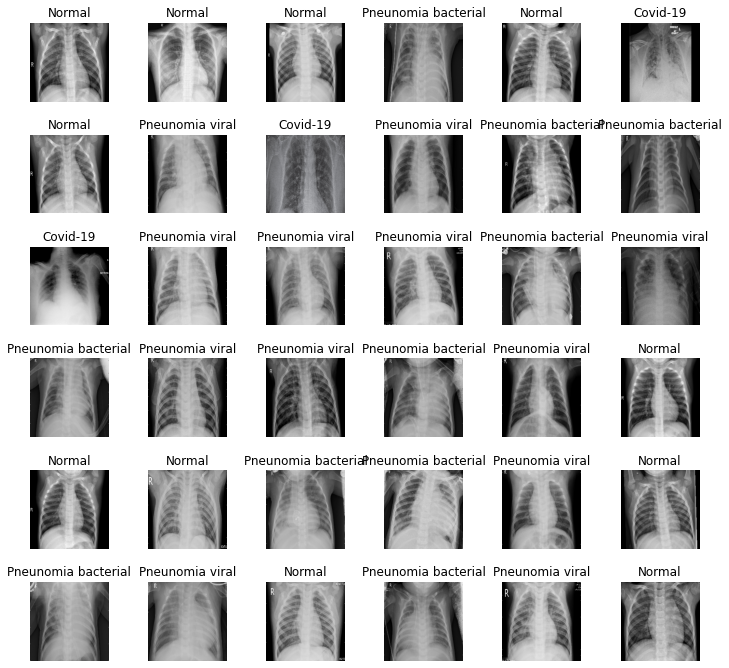

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel() #ravel transforma matriz em vetor
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i]) #puxa as imagens
  axes[i].set_title(labels_names[np.argmax(train_labels[i])]) #variavel label_names, que tem os nomes das classificações
  axes[i].axis('off') #não visualiza os eixos, melhor para imagens
plt.subplots_adjust(wspace=0.5) #espaço entre as imagens para melhor visualização

## Carregamento da rede neural com pesos pré-treinados

In [ ]:
#Modelo Base do ResNet
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


- Com o "include_top" igual à True, estariamos incluindo o topo da rede neural, as camadas densas, onde ocorre a classificação da minha rede neural, e não queremos isso, pois vamos construir nossa própria arquitetura de camadas densas, para classificar nossas 4 classes possíveis de diagnóstico.

- No "input_tensor", passamos os parâmetros iguais aos declarados anteriormente, no meu "train_generator", por exemplo.

In [ ]:
#Observando camadas do meu modelo base
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Quantidade de camadas
len(base_model.layers)

175

Precisamos congelar os pesos das nossas camadas convulocionais, pois vamos repassá-los para nosso novo modelo, portanto, quando formos treinar nossa rede neural, essa parte não pode ser treinada/alterada, e sim utilizar os mesmos pesos uqe já estão definidos no download que fizemos.

In [ ]:
for layer in base_model.layers[:-10]: #Exceto as ultimas 10 camadas, que iremos treinar para melhor adaptação às nossas imagens
  layers.trainable = False #Essas camadas não serão treinadas

## Construção e treinamento do modelo de deep learning

In [ ]:
#Topo da nossa Rede Neural
head_model = base_model.output #Iniciar na saida do 'base_model'
head_model = AveragePooling2D()(head_model) #Reduzindo a dimensionalidade  das imagens e ligando ao 'head_model"
head_model = Flatten()(head_model) #Convertendo os dados de matriz para vetor, para enviar para nossa rede neural densa
head_model = Dense(256, activation = 'relu')(head_model) #Criando nossas camadas densas, com 256 neurônios
head_model = Dropout(0.2)(head_model) #Dropout zera 20% dos neurônios da camada anterior, com o objetivo de evitar um overfitting(adaptção) com as imagens
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model) #Saída/Resposta / 'softmax' serve para classificação de mais de 2 classes

In [ ]:
#Criando modelo
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
#Compilando e definindo alguns parâmetros 
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [ ]:
#Checkpoint para salvar a Rede Neural
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [ ]:
#Redefinir variável, alterando o batch_size para 4, para análise ser feita de 4 em 4 imagens, evitando erros
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
#Variavel para historico do treinamento
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

Epoch 1/25
133/133 [==============================] - 33s 250ms/step - loss: 6.3621e-05 - accuracy: 1.0000
Epoch 2/25
133/133 [==============================] - 33s 245ms/step - loss: 0.0032 - accuracy: 0.9981
Epoch 3/25
133/133 [==============================] - 32s 244ms/step - loss: 1.6521e-06 - accuracy: 1.0000
Epoch 4/25
133/133 [==============================] - 33s 244ms/step - loss: 6.1158e-05 - accuracy: 1.0000
Epoch 5/25
133/133 [==============================] - 33s 245ms/step - loss: 7.5037e-06 - accuracy: 1.0000
Epoch 6/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0207 - accuracy: 0.9981
Epoch 7/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0422 - accuracy: 0.9962
Epoch 8/25
133/133 [==============================] - 33s 249ms/step - loss: 0.0634 - accuracy: 0.9925
Epoch 9/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0242 - accuracy: 0.9962
Epoch 10/25
133/133 [==============================] - 33

## Avaliação da rede neural

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

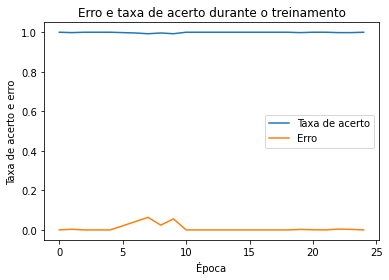

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [ ]:
test_directory = 'CAMINHO'

In [ ]:
os.listdir(test_directory)

['3', '2', '0', '1']

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')
#Mesmos parâmetros da base de treinamento

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator) #enviar imagens para avaliação

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
#Retorno do modelo
evaluate

[6.173990726470947, 0.800000011920929]

80% de Taxa de Acerto

In [ ]:
len(os.listdir(test_directory))

4

In [ ]:
prediction = [] #lista para previsões
original = [] #lista para classficação original
image = [] #lista para imagem

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))): #percorrendo todas imagens em todos diretorios
    img = cv2.imread(os.path.join(test_directory, str(i), item)) #carregando img via OpenCV
    img = cv2.resize(img, (256, 256)) #ajustando pro tamanho 256x256, tamanho padrão de nossa rede neural
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
#Previsões para cada imagem
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 1]


In [ ]:
#Classificação real para compartivo/validação
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
#Calculando Accuracy
accuracy_score(original, prediction)

0.775

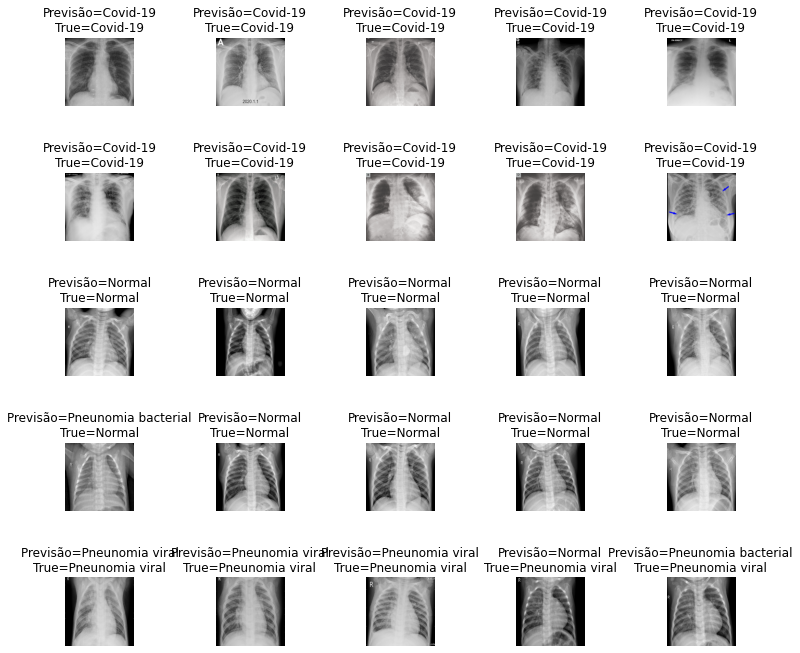

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

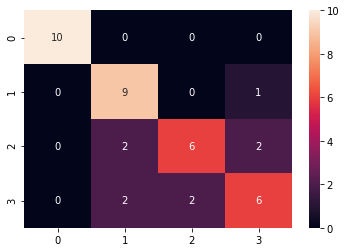

In [ ]:
#Matriz de Confusão
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.69      0.90      0.78        10
           2       0.75      0.60      0.67        10
           3       0.67      0.60      0.63        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



- Nosso modelo é altamente preciso quando se trata da classificação de Covid (Precision e Recall de 1.0, 100% de precisão/acerto)